In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import xgboost as xgb
from sklearn.metrics import mean_squared_error

In [2]:
# this is our target
y_CME3MSOFR = pd.read_csv(f"../data/CME3MSOFR.csv")
y_CME3MSOFR = y_CME3MSOFR.dropna(axis="columns")
y_CME3MSOFR.drop(columns=["dd", "mm", "yyyy"], inplace=True)
y_CME3MSOFR.columns = ["date", "y_rate_CME3MSOFR"]
y_CME3MSOFR["date"] = pd.to_datetime(y_CME3MSOFR["date"])
# flip it so that first row
y_CME3MSOFR = y_CME3MSOFR.iloc[::-1]
y_CME3MSOFR.reset_index(inplace=True)
y_CME3MSOFR = y_CME3MSOFR.drop(columns=["index"])
print(y_CME3MSOFR.head())

        date  y_rate_CME3MSOFR
0 2019-01-03            2.4328
1 2019-01-04            2.4296
2 2019-01-07            2.4276
3 2019-01-08            2.4298
4 2019-01-09            2.4390


In [3]:
# check NA
print(y_CME3MSOFR[y_CME3MSOFR.isna().any(axis=1)])
# describe the data
print(y_CME3MSOFR.describe())

Empty DataFrame
Columns: [date, y_rate_CME3MSOFR]
Index: []
       y_rate_CME3MSOFR
count       1199.000000
mean           1.821782
std            1.884534
min            0.016000
25%            0.069150
50%            1.579000
75%            2.665290
max            5.422450


In [4]:
# this is our feature
# 3MSOFRFuture
x_3MSOFRFuture = pd.read_csv(f"../data/3MSOFRFuture.csv")
x_3MSOFRFuture = x_3MSOFRFuture.dropna(axis="columns")
x_3MSOFRFuture.drop(columns=["dd", "mm", "yyyy"], inplace=True)
x_3MSOFRFuture.columns = ["date", "x_price_3MSOFRFuture"]
x_3MSOFRFuture["date"] = pd.to_datetime(x_3MSOFRFuture["date"])
# flip it so that first row
x_3MSOFRFuture = x_3MSOFRFuture.iloc[::-1]
x_3MSOFRFuture.reset_index(inplace=True)
x_3MSOFRFuture = x_3MSOFRFuture.drop(columns=["index"])
print(x_3MSOFRFuture.head())

        date  x_price_3MSOFRFuture
0 2018-12-14                97.370
1 2018-12-17                97.405
2 2018-12-18                97.455
3 2018-12-19                97.460
4 2018-12-20                97.470


In [5]:
# check NA
print(x_3MSOFRFuture[x_3MSOFRFuture.isna().any(axis=1)])
# describe the data
print(x_3MSOFRFuture.describe())

Empty DataFrame
Columns: [date, x_price_3MSOFRFuture]
Index: []
       x_price_3MSOFRFuture
count           1247.000000
mean              97.822650
std                1.834714
min               94.305000
25%               96.332500
50%               98.515000
75%               99.380000
max               99.990000


In [6]:
# this is our feature
# USTbill3M
x_USTbill3M = pd.read_csv(f"../data/USTbill3M.csv")
x_USTbill3M = x_USTbill3M.dropna(axis="columns")
x_USTbill3M.columns = ["date", "x_rate_USTbill3M"]
x_USTbill3M["date"] = pd.to_datetime(x_USTbill3M["date"])
# no need flip, already in correct order
print(x_USTbill3M.head())

        date  x_rate_USTbill3M
0 2018-11-26            2.3775
1 2018-11-27            2.3771
2 2018-11-28            2.3704
3 2018-11-29            2.3616
4 2018-11-30            2.3654


In [7]:
# check NA
print(x_USTbill3M[x_USTbill3M.isna().any(axis=1)])
# describe the data
print(x_USTbill3M.describe())

Empty DataFrame
Columns: [date, x_rate_USTbill3M]
Index: []
       x_rate_USTbill3M
count       1250.000000
mean           1.866989
std            1.902441
min           -0.031200
25%            0.090225
50%            1.556850
75%            2.700375
max            5.491500


In [8]:
# USD3MOIS this is weird data
x_USD3MOIS = pd.read_csv(f"../data/USD3MOIS.csv")
x_USD3MOIS.columns = ["date", "bid", "ask"]
x_USD3MOIS["date"] = pd.to_datetime(x_USD3MOIS["date"])
x_USD3MOIS["x_mid_USD3MOIS"] = 0.5 * (x_USD3MOIS["bid"] + x_USD3MOIS["ask"])
# flip it so that first row
x_USD3MOIS = x_USD3MOIS.iloc[::-1]
x_USD3MOIS = x_USD3MOIS.drop(columns=["bid", "ask"])
print(x_USD3MOIS.head())

           date  x_mid_USD3MOIS
1515 2018-01-02           1.439
1514 2018-01-03           1.444
1513 2018-01-04           1.454
1512 2018-01-05           1.454
1511 2018-01-08           1.457


In [9]:
to_concat = [x_3MSOFRFuture, x_USTbill3M, x_USD3MOIS]
df_concat = y_CME3MSOFR
for frames in to_concat:
    df_concat = pd.merge(df_concat, frames, on="date", how="left")
    print(df_concat.isna().sum())
print(df_concat.describe())

date                    0
y_rate_CME3MSOFR        0
x_price_3MSOFRFuture    0
dtype: int64
date                    0
y_rate_CME3MSOFR        0
x_price_3MSOFRFuture    0
x_rate_USTbill3M        1
dtype: int64
date                    0
y_rate_CME3MSOFR        0
x_price_3MSOFRFuture    0
x_rate_USTbill3M        1
x_mid_USD3MOIS          0
dtype: int64
       y_rate_CME3MSOFR  x_price_3MSOFRFuture  x_rate_USTbill3M  \
count       1199.000000           1199.000000       1198.000000   
mean           1.821782             97.893874          1.781852   
std            1.884534              1.801295          1.868201   
min            0.016000             94.305000         -0.031200   
25%            0.069150             96.635000          0.087600   
50%            1.579000             98.550000          1.541100   
75%            2.665290             99.392500          2.506525   
max            5.422450             99.990000          5.470100   

       x_mid_USD3MOIS  
count     1199.000000

In [10]:
df_concat = df_concat.fillna(method="ffill")
df_concat

,date,y_rate_CME3MSOFR,x_price_3MSOFRFuture,x_rate_USTbill3M,x_mid_USD3MOIS
0,2019-01-03,2.43280,97.8350,2.3919,2.3930
1,2019-01-04,2.42960,97.7700,2.4058,2.4040
2,2019-01-07,2.42760,97.7250,2.4127,2.4070
3,2019-01-08,2.42980,97.6550,2.4243,2.4150
4,2019-01-09,2.43900,97.6650,2.4213,2.4100
...,...,...,...,...,...
1194,2023-11-14,5.37972,94.6500,5.4014,5.3649
1195,2023-11-15,5.39021,94.6500,5.4061,5.3686
1196,2023-11-16,5.36937,94.6500,5.3972,5.3662
1197,2023-11-17,5.36710,94.6525,5.3969,5.3696


In [11]:
df_concat.set_index("date", inplace=True)

In [12]:
df_concat.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 1199 entries, 2019-01-03 to 2023-11-21
Data columns (total 4 columns):
 #   Column                Non-Null Count  Dtype  
---  ------                --------------  -----  
 0   y_rate_CME3MSOFR      1199 non-null   float64
 1   x_price_3MSOFRFuture  1199 non-null   float64
 2   x_rate_USTbill3M      1199 non-null   float64
 3   x_mid_USD3MOIS        1199 non-null   float64
dtypes: float64(4)
memory usage: 46.8 KB


In [13]:
# df_concat.index = pd.to_datetime(df_concat.index)
# train = df_concat.loc[df_concat.index < pd.to_datetime("2023-01-01")]
# test = df_concat.loc[df_concat.index >= pd.to_datetime("2023-01-01")]

# fig, ax = plt.subplots()
# train["y_rate_CME3MSOFR"].plot(
#    ax=ax, label="Training Set", title="Data Train/Test Split : y_rate_CME3MSOFR"
# )
# test["y_rate_CME3MSOFR"].plot(ax=ax, label="Test Set")
# ax.axvline(pd.to_datetime("2023-01-01"), color="black", ls="--")
# plt.show()

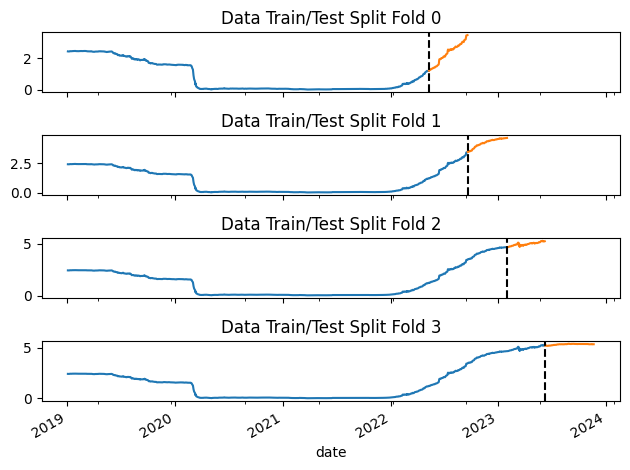

In [14]:
from sklearn.model_selection import TimeSeriesSplit

tss = TimeSeriesSplit(n_splits=4, test_size=90)

fig, axs = plt.subplots(4, 1, sharex=True)

fold = 0
for train_idx, val_idx in tss.split(df_concat):
    train = df_concat.iloc[train_idx]
    test = df_concat.iloc[val_idx]
    train["y_rate_CME3MSOFR"].plot(
        ax=axs[fold], label="Training Set", title=f"Data Train/Test Split Fold {fold}"
    )
    test["y_rate_CME3MSOFR"].plot(ax=axs[fold], label="Test Set")
    axs[fold].axvline(test.index.min(), color="black", ls="--")
    fold += 1
plt.tight_layout()
plt.show()

## TIME FEATURE ##

In [15]:
def create_features(df):
    """
    Create time series features based on time series index.
    """
    df = df.copy()
    df["dayofweek"] = df.index.dayofweek
    # df["quarter"] = df.index.quarter
    df["year"] = df.index.year
    df["month"] = df.index.month
    df["dayofmonth"] = df.index.day
    df["dayofyear"] = df.index.dayofyear
    df["duration"] = pd.to_timedelta(df.index - df.index.min()).astype("timedelta64[D]")
    # df["weekofyear"] = df.index.isocalendar().week
    return df

In [16]:
#  df_concat = create_features(df_concat)
df_concat.head()

,y_rate_CME3MSOFR,x_price_3MSOFRFuture,x_rate_USTbill3M,x_mid_USD3MOIS
date,,,,
2019-01-03,2.4328,97.835,2.3919,2.393
2019-01-04,2.4296,97.770,2.4058,2.404
2019-01-07,2.4276,97.725,2.4127,2.407
2019-01-08,2.4298,97.655,2.4243,2.415
2019-01-09,2.4390,97.665,2.4213,2.410


## Feature Lagging ##

In [17]:
to_shift = [
    "y_rate_CME3MSOFR",
    "x_price_3MSOFRFuture",
    "x_rate_USTbill3M",
    "x_mid_USD3MOIS",
]

In [18]:
def add_lags(df, shiftrate):
    # target_map = df["y_rate_CME3MSOFR"].to_dict(
    for x in to_shift:
        df[f"{x}_lag"] = df[x].shift(shiftrate)
    return df

In [19]:
df = add_lags(df_concat, 1)
df.head(10)

,y_rate_CME3MSOFR,x_price_3MSOFRFuture,x_rate_USTbill3M,x_mid_USD3MOIS,y_rate_CME3MSOFR_lag,x_price_3MSOFRFuture_lag,x_rate_USTbill3M_lag,x_mid_USD3MOIS_lag
date,,,,,,,,
2019-01-03,2.4328,97.835,2.3919,2.393,NaN,NaN,NaN,NaN
2019-01-04,2.4296,97.770,2.4058,2.404,2.4328,97.835,2.3919,2.393
2019-01-07,2.4276,97.725,2.4127,2.407,2.4296,97.770,2.4058,2.404
2019-01-08,2.4298,97.655,2.4243,2.415,2.4276,97.725,2.4127,2.407
2019-01-09,2.4390,97.665,2.4213,2.410,2.4298,97.655,2.4243,2.415
2019-01-10,2.4481,97.660,2.4232,2.413,2.4390,97.665,2.4213,2.410
2019-01-11,2.4448,97.675,2.4222,2.410,2.4481,97.660,2.4232,2.413
2019-01-14,2.4423,97.670,2.4234,2.409,2.4448,97.675,2.4222,2.410
2019-01-15,2.4467,97.680,2.4171,2.407,2.4423,97.670,2.4234,2.409


In [26]:
df[df.isna().any(axis=1)]

,y_rate_CME3MSOFR,x_price_3MSOFRFuture,x_rate_USTbill3M,x_mid_USD3MOIS,y_rate_CME3MSOFR_lag,x_price_3MSOFRFuture_lag,x_rate_USTbill3M_lag,x_mid_USD3MOIS_lag,dayofweek,year,month,dayofmonth,dayofyear,duration
date,,,,,,,,,,,,,,
2019-01-03,2.4328,97.835,2.3919,2.393,NaN,NaN,NaN,NaN,3,2019,1,3,3,0.0


## TRAINING WITH CROSS VALIDATION ##

In [20]:
split = 4
test_count = 100
tss = TimeSeriesSplit(n_splits=split, test_size=test_count)
df = df.sort_index()

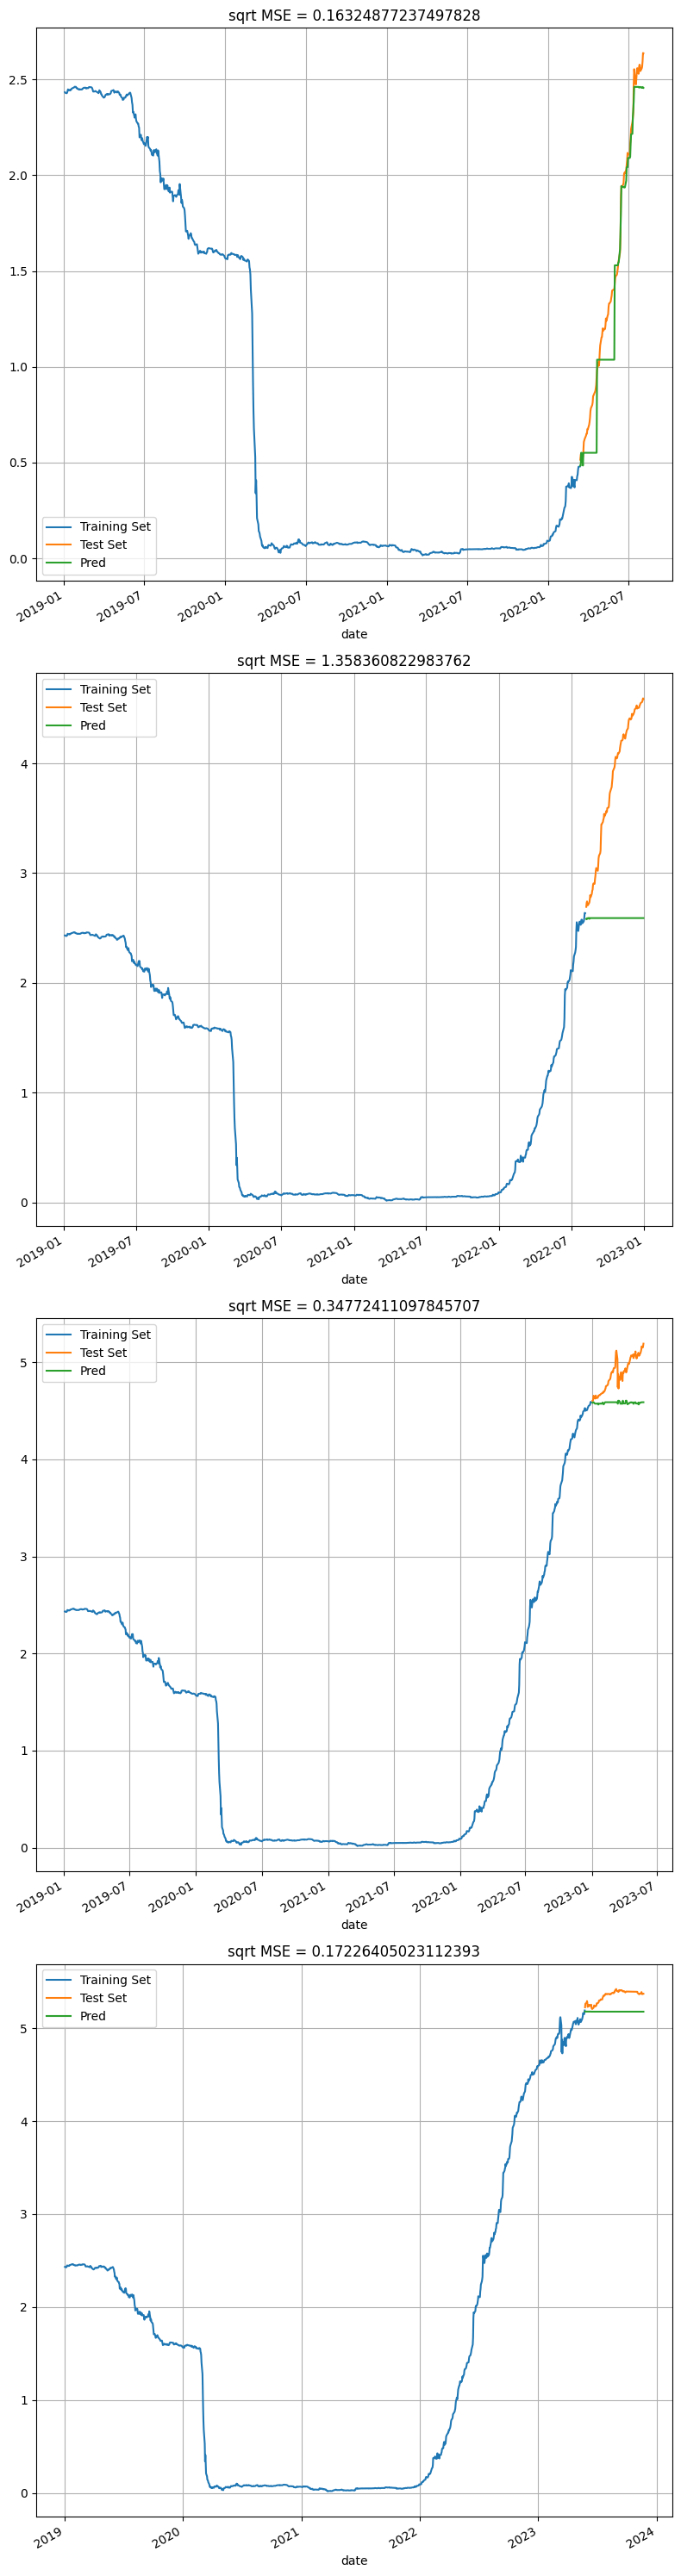

In [21]:
fold = 0
preds = []
scores = []
fig, ax = plt.subplots(split, figsize=(8, 30))
for train_idx, val_idx in tss.split(df):
    train = df.iloc[train_idx]
    test = df.iloc[val_idx]

    train = create_features(train)
    test = create_features(test)

    FEATURES = [
        "y_rate_CME3MSOFR_lag",
        "x_price_3MSOFRFuture_lag",
        "x_rate_USTbill3M_lag",
        "x_mid_USD3MOIS_lag",
    ]
    TARGET = "y_rate_CME3MSOFR"

    X_train = train[FEATURES]
    y_train = train[TARGET]

    X_test = test[FEATURES]
    y_test = test[TARGET]
    """
    reg = xgb.XGBRegressor(
        base_score=0.5,
        booster="gbtree",
        n_estimators=1000,
        early_stopping_rounds=50,
        objective="reg:linear",
        max_depth=3,
        learning_rate=0.01,
    )
    """
    # reg.fit(
    #    X_train, y_train, eval_set=[(X_train, y_train), (X_test, y_test)], verbose=100
    # )
    reg = xgb.XGBRegressor(n_estimators=10000)
    reg.fit(
        X_train, y_train, eval_set=[(X_train, y_train), (X_test, y_test)], verbose=False
    )
    y_pred = reg.predict(X_test)
    y_train.plot(ax=ax[fold], label="Training Set")
    y_test.plot(ax=ax[fold], label="Test Set")

    df_y_pred = pd.DataFrame(y_pred, index=y_test.index, columns=["Pred"])
    df_y_pred.plot(ax=ax[fold])
    ax[fold].legend()

    preds.append(y_pred)
    score = np.sqrt(mean_squared_error(y_test, y_pred))
    scores.append(score)
    ax[fold].set_title(f"sqrt MSE = {score}")
    ax[fold].grid()

    fold += 1
fig.tight_layout()
plt.show()

In [22]:
print(f"Score across folds {np.mean(scores):0.4f}")
print(f"Fold scores:{scores}")

Score across folds 0.5104
Fold scores:[0.16324877237497828, 1.358360822983762, 0.34772411097845707, 0.17226405023112393]


In [23]:
# Retrain on all data, is this needed?
df = create_features(df)

FEATURES = [
    "y_rate_CME3MSOFR_lag1",
    "x_price_3MSOFRFuture",
    "x_rate_USTbill3M",
    "x_mid_USD3MOIS",
    "x_price_3MSOFRFuture_lag1",
    "x_rate_USTbill3M_lag1",
    "x_mid_USD3MOIS_lag1",
]
TARGET = "y_rate_CME3MSOFR"

X_all = df[FEATURES]
y_all = df[TARGET]

reg = xgb.XGBRegressor(
    base_score=0.5,
    booster="gbtree",
    n_estimators=500,
    objective="reg:linear",
    max_depth=3,
    learning_rate=0.01,
)
reg.fit(X_all, y_all, eval_set=[(X_all, y_all)], verbose=100)
reg

KeyError: "['y_rate_CME3MSOFR_lag1', 'x_price_3MSOFRFuture_lag1', 'x_rate_USTbill3M_lag1', 'x_mid_USD3MOIS_lag1'] not in index"

In [ ]:
from sklearn.model_selection import train_test_split
import statsmodels.api as sm
from statsmodels.tsa.stattools import adfuller

# Extract feature and target arrays
adfuller(df_concat["y_rate_CME3MSOFR"].dropna())

(0.09670383850432242,
 0.9658353279811982,
 19,
 1179,
 {'1%': -3.4359086044391476,
  '5%': -2.863994554693699,
  '10%': -2.5680768554093008},
 -5587.969739956731)

In [ ]:
# try diff once !
df_concat["y_rate_CME3MSOFR_diff1"] = df_concat["y_rate_CME3MSOFR"].diff()
adfuller(df_concat["y_rate_CME3MSOFR_diff1"].dropna())

(-4.562389170124363,
 0.00015143610186267432,
 18,
 1179,
 {'1%': -3.4359086044391476,
  '5%': -2.863994554693699,
  '10%': -2.5680768554093008},
 -5584.174151454393)

## Markov Switching Dynamic Regression ##
https://www.statsmodels.org/dev/examples/notebooks/generated/markov_regression.html

In [ ]:
# Fit the model, lets try lagged t-1 rates
mod_kns = sm.tsa.MarkovRegression(
    df_concat["y_rate_CME3MSOFR"].iloc[1:],
    k_regimes=3,
    switching_variance=True,
)
res_kns = mod_kns.fit()
res_kns.summary()

c:\Users\kilohp\AppData\Local\Programs\Python\Python311\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
c:\Users\kilohp\AppData\Local\Programs\Python\Python311\Lib\site-packages\statsmodels\tsa\regime_switching\markov_switching.py:1291: EstimationWarning: Invalid regime transition probabilities estimated in EM iteration; probabilities have been re-scaled to continue estimation.
  warnings.warn('Invalid regime transition probabilities'
c:\Users\kilohp\AppData\Local\Programs\Python\Python311\Lib\site-packages\statsmodels\tsa\regime_switching\markov_switching.py:1291: EstimationWarning: Invalid regime transition probabilities estimated in EM iteration; probabilities have been re-scaled to continue estimation.
  warnings.warn('Invalid regime transition probabilities'
c:\Users\kilohp\AppData\Local\Programs\Python\

KeyboardInterrupt: 

In [ ]:
plt.plot(df_concat["date"], df_concat["y_rate_CME3MSOFR"])
plt.grid()

KeyError: 'date'

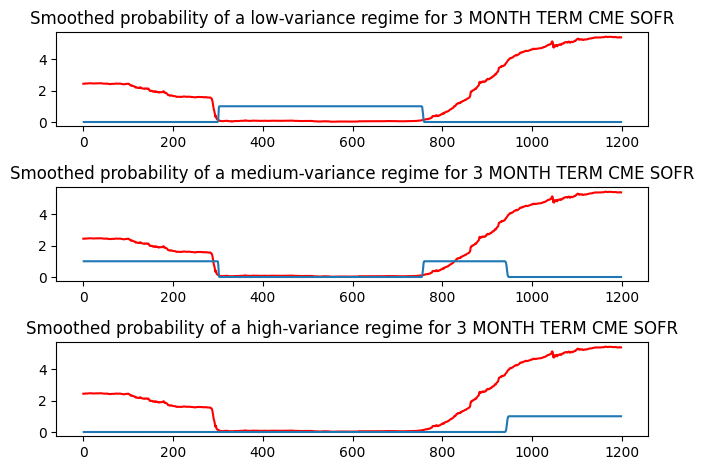

In [ ]:
fig, axes = plt.subplots(3)
ax = axes[0]
ax.plot(df_concat["y_rate_CME3MSOFR"], color="red")
ax.plot(res_kns.smoothed_marginal_probabilities[0])
ax.set(title="Smoothed probability of a low-variance regime for 3 MONTH TERM CME SOFR")
ax = axes[1]
ax.plot(df_concat["y_rate_CME3MSOFR"], color="red")
ax.plot(res_kns.smoothed_marginal_probabilities[1])
ax.set(
    title="Smoothed probability of a medium-variance regime for 3 MONTH TERM CME SOFR"
)
ax = axes[2]
ax.plot(df_concat["y_rate_CME3MSOFR"], color="red")
ax.plot(res_kns.smoothed_marginal_probabilities[2])
ax.set(title="Smoothed probability of a high-variance regime for 3 MONTH TERM CME SOFR")
fig.tight_layout()

In [ ]:
print(res_kns.expected_durations)

[369.38225516 347.48006566 696.05628148]


## Simple XGBOOST ##

In [ ]:
df_simple = pd.DataFrame(df_concat["y_rate_CME3MSOFR"])
df_simple["x_lagged"] = df_simple["y_rate_CME3MSOFR"].shift(1)
df_simple

,y_rate_CME3MSOFR,x_lagged
0,2.43280,NaN
1,2.42960,2.43280
2,2.42760,2.42960
3,2.42980,2.42760
4,2.43900,2.42980
...,...,...
1194,5.37972,5.37764
1195,5.39021,5.37972
1196,5.36937,5.39021
1197,5.36710,5.36937


In [ ]:
X = df_simple["x_lagged"]
y = df_simple["y_rate_CME3MSOFR"]

In [ ]:
X

0           NaN
1       2.43280
2       2.42960
3       2.42760
4       2.42980
         ...   
1194    5.37764
1195    5.37972
1196    5.39021
1197    5.36937
1198    5.36710
Name: x_lagged, Length: 1199, dtype: float64

In [ ]:
X_train = X.iloc[:-500].to_numpy()
X_test = X.iloc[-500:].to_numpy()
y_train = y.iloc[:-500].to_numpy()
y_test = y.iloc[-500:].to_numpy()

In [ ]:
X_train = np.reshape(X_train, (-1, 1))
X_test = np.reshape(X_test, (-1, 1))
y_train = np.reshape(y_train, (-1, 1))
y_test = np.reshape(y_test, (-1, 1))

In [ ]:
reg = xgb.XGBRegressor(n_estimators=10000)
reg.fit(
    X_train, y_train, eval_set=[(X_train, y_train), (X_test, y_test)], verbose=False
)

XGBRegressor(base_score=None, booster=None, callbacks=None,
             colsample_bylevel=None, colsample_bynode=None,
             colsample_bytree=None, device=None, early_stopping_rounds=None,
             enable_categorical=False, eval_metric=None, feature_types=None,
             gamma=None, grow_policy=None, importance_type=None,
             interaction_constraints=None, learning_rate=None, max_bin=None,
             max_cat_threshold=None, max_cat_to_onehot=None,
             max_delta_step=None, max_depth=None, max_leaves=None,
             min_child_weight=None, missing=nan, monotone_constraints=None,
             multi_strategy=None, n_estimators=10000, n_jobs=None,
             num_parallel_tree=None, random_state=None, ...)

<Axes: title={'center': 'Feature importance'}, xlabel='F score', ylabel='Features'>

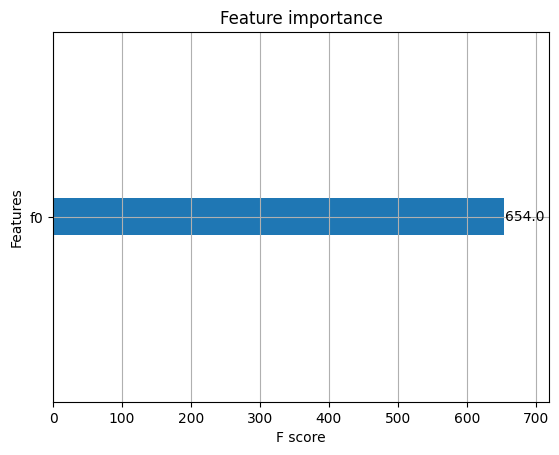

In [ ]:
xgb.plot_importance(reg)

In [ ]:
X_test

array([[0.05372],
       [0.0515 ],
       [0.04539],
       [0.04731],
       [0.04546],
       [0.0476 ],
       [0.04653],
       [0.04764],
       [0.04776],
       [0.04819],
       [0.04784],
       [0.04774],
       [0.04603],
       [0.04439],
       [0.04479],
       [0.04643],
       [0.0461 ],
       [0.0461 ],
       [0.04979],
       [0.05004],
       [0.0512 ],
       [0.05338],
       [0.05315],
       [0.05278],
       [0.05155],
       [0.05384],
       [0.05556],
       [0.05575],
       [0.05353],
       [0.05363],
       [0.05413],
       [0.05586],
       [0.05521],
       [0.05569],
       [0.05742],
       [0.05848],
       [0.05885],
       [0.05903],
       [0.05886],
       [0.06211],
       [0.06659],
       [0.07081],
       [0.06436],
       [0.06547],
       [0.0672 ],
       [0.07579],
       [0.07521],
       [0.07862],
       [0.07907],
       [0.08216],
       [0.09281],
       [0.09125],
       [0.0911 ],
       [0.09274],
       [0.09317],
       [0.

In [ ]:
# create prediction dataframe
pred = y_test.copy()
pred_result = reg.predict(X_test)

<Axes: title={'center': 'simple XGBOOST'}>

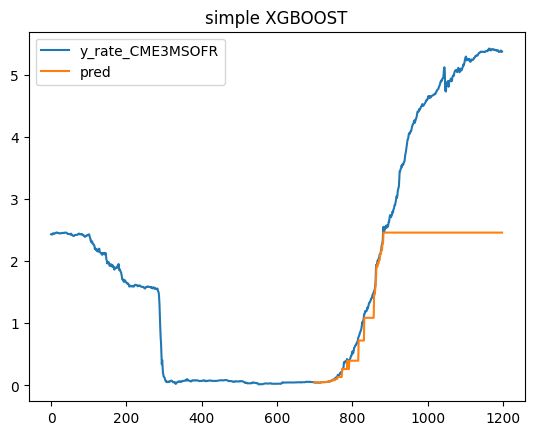

In [ ]:
# hackmode use nan
result = pd.DataFrame(y)
a = np.full(len(y_train), np.nan)
a = np.append(a, pred_result)
result["pred"] = a
result.plot(title="simple XGBOOST")

In [ ]:
from sklearn.metrics import mean_squared_error

# evaluate predictions
mse = mean_squared_error(pred_result, y_test)
mse

3.2858974103163456